# 1 - Genome Wide Association Study with DaTSCAN data

In [1]:
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import math
import sys
import os

## Introduction

During this step of the workflow we will compute the SNP-PD associations, using DaTSCAN imaging information to improve the phenotypic associations.

During the Individual View step, we will focus on finding candidate SNP biomarkers by integrating genetic and neuroimaging data. During this phase, we search for SNP-disease associations accounting for the phenotypic information carried by each imaging measure separately, and by integrating the single results obtained, in order to retrieve comprehensive potential SNP biomarkers for each imaging type considered. 

Thus, we will merge the results obtained using DaTSCAN features in a single results dataset.

To combine the results obtained, we use TATES (Van der Sluis *et al*., 2013), which combines the *P*-values in a single-trait-based statistical significance, by correcting for correlation among the imaging features, and evaluating if at least one of the analyzed traits could be associated with a SNP.

In [2]:
genotyping_path = "../../data/genotyping/"
imaging_path = "../../data/imaging/"
patdocs_path = "../../data/patient_docs/"
datscan_path = os.path.join(imaging_path, "DaTSCAN")
mri_path = os.path.join(imaging_path, "MRI")

## GWAS with DaTSCAN features

### Exploring normalized DaTSCAN data

During the previous steps of the workflow we normalized the DaTSCAN data with rank based inverse normal transformation (r-INT).

As previously discussed, we normalized DaTSCAN data because the measurements fell in different range of values. To normalize our data we applied r-INT, in order to provide a normalization procedure less susceptible to outlier values.

In [3]:
datscan = pd.read_csv(
    os.path.join(datscan_path, "DATScan_Analysis_eu_fv_norm.csv")
)
datscan.head(n=10)

PATNO EVENT_ID   SCAN_DATE  CAUDATE_R  CAUDATE_L  PUTAMEN_R  PUTAMEN_L
0   3000       SC  2011-01-20   0.932467   1.368655   1.786562   1.448689
1   3001      U01  2011-06-23  -0.313764  -0.507784  -0.313764  -0.648172
2   3002      U01  2011-06-28   0.835925   1.656152   0.032656   0.696547
3   3004      U01  2011-08-24   2.971827   2.971827   2.383049   1.882275
4   3006       SC  2011-08-02   0.038596  -0.188099  -0.408846  -2.499599
5   3008       SC  2011-08-30   1.957186   1.407545   0.941676   1.023443
6   3011       SC  2011-07-07   1.600299   1.848464   2.095619   1.611072
7   3012       SC  2011-10-11  -0.221442  -0.276558  -2.021570  -0.434802
8   3016       SC  2012-01-17   1.510772   1.558962   1.611072   1.262883
9   3018       SC  2012-02-29  -0.360897  -1.018445  -0.823362  -1.730834

### Constructing Phenotype and Covariate files

Before finding statistically significant SNP-phenotype associations with PLINK we need to define two files which are used by the tool to compute the linear model, used during SNP-trait associations:

- phenotype file

- covariate file

The phenotype file contains the phenotypic information we want to add to the model, in our study we add subjects enrolment category (HC or PD) and the imaging feature values.

The covariate file contains all the confounders used to adjust the linear model, in ourstudy we used as covariates the subjects' age and the first 10 principal components of the SNP relatedness matrix.

Let's begin by creating the phenotype file.

In [4]:
pheno_fn = os.path.join(genotyping_path, "phenotype_datscan.txt")

# load the subjects enrolment status and demographics informations
status = pd.read_csv(
    os.path.join(patdocs_path, "Patient_Status.csv")
)

# load the IDs of subjects considered in our study
eu_pats_ds = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_eu_woswedd_ds.fam"),
    header=None,
    sep=" "
)

# retrieve status info and demographics for our subjects
status_eu_ds = status[status["PATNO"].isin(eu_pats_ds.iloc[:,0].tolist())]
status_eu_ds.reset_index(inplace=True, drop=True)
status_eu_ds.head(n=10)

PATNO RECRUITMENT_CAT IMAGING_CAT ENROLL_DATE ENROLL_CAT ENROLL_STATUS  \
0   3000              HC          HC     02/2011         HC      Enrolled   
1   3001              PD          PD     03/2011         PD      Enrolled   
2   3002              PD          PD     03/2011         PD      Enrolled   
3   3004              HC          HC     04/2011         HC      Enrolled   
4   3006              PD          PD     05/2011         PD      Withdrew   
5   3008              HC          HC     06/2011         HC      Enrolled   
6   3011              HC          HC     07/2011         HC      Withdrew   
7   3012              PD          PD     11/2011         PD      Enrolled   
8   3016              HC          HC     02/2012         HC      Enrolled   
9   3018              PD          PD     04/2012         PD      Enrolled   

  DESCRP_CAT STATUS_DATE  
0        NaN     02/2011  
1        NaN     03/2011  
2        NaN     03/2011  
3        NaN     04/2011  
4        NaN     10/2013  
5        NaN     06/2011  
6        NaN     07/2014  
7        NaN     11/2011  
8        NaN     02/2012  
9        NaN     04/2012

In [5]:
phenotype = status_eu_ds.merge(datscan, on=["PATNO"])
phenotype["FID"] = phenotype.iloc[:,0].tolist()  # add the FID
phenotype["ENROLL_CAT"] = np.where(phenotype["ENROLL_CAT"] == "HC", 1, 2)  # HC == 1, PD == 2
# extract the columns of interest
phenotype = phenotype.loc[:,["FID", "PATNO", "ENROLL_CAT", "CAUDATE_R", "CAUDATE_L", "PUTAMEN_R", "PUTAMEN_L"]]
phenotype = phenotype.rename({"PATNO":"IID"}, axis=1)
phenotype.head(n=10)

FID   IID  ENROLL_CAT  CAUDATE_R  CAUDATE_L  PUTAMEN_R  PUTAMEN_L
0  3000  3000           1   0.932467   1.368655   1.786562   1.448689
1  3001  3001           2  -0.313764  -0.507784  -0.313764  -0.648172
2  3002  3002           2   0.835925   1.656152   0.032656   0.696547
3  3004  3004           1   2.971827   2.971827   2.383049   1.882275
4  3006  3006           2   0.038596  -0.188099  -0.408846  -2.499599
5  3008  3008           1   1.957186   1.407545   0.941676   1.023443
6  3011  3011           1   1.600299   1.848464   2.095619   1.611072
7  3012  3012           2  -0.221442  -0.276558  -2.021570  -0.434802
8  3016  3016           1   1.510772   1.558962   1.611072   1.262883
9  3018  3018           2  -0.360897  -1.018445  -0.823362  -1.730834

We can now store phenotypic data to a TXT file called ```phenotype.txt```.

In [6]:
phenotype.to_csv(
    os.path.join(genotyping_path, pheno_fn),
    header=True,
    index=False,
    sep=" "
)

Let's now create the covariate file.

In [7]:
demo = pd.read_csv(
    os.path.join(patdocs_path, "Screening___Demographics.csv")
)
demo = demo[demo["PATNO"].isin(eu_pats_ds.iloc[:,0].tolist())].sort_values(["PATNO"])
demo.reset_index(inplace=True, drop=True)
demo.head(n=10)

REC_ID F_STATUS  PATNO EVENT_ID PAG_NAME  SIGNCNST CONSNTDT  APPRDX  \
0  269535301        V   3000  CONSENT   SCREEN       1.0  01/2011     2.0   
1  274783501        V   3001  CONSENT   SCREEN       1.0  02/2011     1.0   
2  278717701        S   3002  CONSENT   SCREEN       1.0  03/2011     1.0   
3  281159801        V   3004  CONSENT   SCREEN       1.0  03/2011     2.0   
4  283722401        S   3006  CONSENT   SCREEN       1.0  03/2011     1.0   
5  289807201        V   3008  CONSENT   SCREEN       1.0  05/2011     2.0   
6  302607101        V   3011  CONSENT   SCREEN       1.0  06/2011     2.0   
7  316309601        V   3012  CONSENT   SCREEN       1.0  10/2011     1.0   
8  329167601        V   3016  CONSENT   SCREEN       1.0  01/2012     2.0   
9  336629801        V   3018  CONSENT   SCREEN       1.0  02/2012     1.0   

   CURRENT_APPRDX  P3GRP  ...  PRJENRDT  REFERRAL  DECLINED  RSNDEC  EXCLUDED  \
0             2.0    NaN  ...   02/2011      31.0       NaN     NaN       NaN   
1             1.0    NaN  ...   03/2011      60.0       NaN     NaN       NaN   
2             1.0    NaN  ...   03/2011       1.0       NaN     NaN       NaN   
3             2.0    NaN  ...   04/2011      99.0       NaN     NaN       NaN   
4             1.0    NaN  ...   04/2011       1.0       NaN     NaN       NaN   
5             2.0    NaN  ...   06/2011       4.0       NaN     NaN       NaN   
6             2.0    NaN  ...   07/2011       1.0       NaN     NaN       NaN   
7             1.0    NaN  ...   11/2011       1.0       NaN     NaN       NaN   
8             2.0    NaN  ...   02/2012       4.0       NaN     NaN       NaN   
9             1.0    NaN  ...   03/2012      60.0       NaN     NaN       NaN   

   RSNEXC  ORIG_ENTRY            LAST_UPDATE  QUERY SITE_APRV  
0     NaN     01/2011  2011-01-19 15:44:58.0    NaN   01/2011  
1     NaN     02/2011  2011-02-10 13:43:30.0    NaN   03/2011  
2     NaN     03/2011  2020-04-01 17:33:42.0    NaN   03/2011  
3     NaN     03/2011  2011-03-30 14:43:13.0    NaN   03/2011  
4     NaN     03/2011  2020-04-22 09:14:39.0    NaN   03/2011  
5     NaN     05/2011  2013-10-31 14:28:09.0    NaN   05/2011  
6     NaN     06/2011  2011-07-22 16:39:28.0    NaN   06/2011  
7     NaN     10/2011  2011-10-12 13:48:43.0    NaN   10/2011  
8     NaN     01/2012  2012-01-12 13:19:24.0    NaN   01/2012  
9     NaN     03/2012  2012-05-17 12:12:53.0    NaN   03/2012  

[10 rows x 30 columns]

Let's now compute the subjects age at the DaTSCAN visit time.

In [8]:
def compute_age(df):
    scan_year = int(df["SCAN_DATE"].split("-")[0])
    birth_year = int(df["BIRTHDT"])
    return (scan_year - birth_year)

x = demo.merge(datscan, on=["PATNO"])
demo["AGE"] = x.apply(compute_age, axis=1)
demo.loc[:, ["PATNO", "AGE"]].head(n=10)  # display subjects age

PATNO  AGE
0   3000   70
1   3001   65
2   3002   68
3   3004   60
4   3006   58
5   3008   82
6   3011   32
7   3012   58
8   3016   58
9   3018   61

Since we removed three subjects from those of step 2 of preprocessing phase we must recompute the PCs of the relatedness matrix in order to have consistent data with our current dataset.

As we did before, to compute the first 20 PCs we use PLINK PCA.

In [9]:
ppmi_eu_woswedd_ds_fn = os.path.join(genotyping_path, "PPMI_eu_woswedd_ds")

!plink --bfile {ppmi_eu_woswedd_ds_fn} --pca 20 --out {ppmi_eu_woswedd_ds_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu_woswedd_ds.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu_woswedd_ds
  --out ../../data/genotyping/PPMI_eu_woswedd_ds
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
422 people (286 males, 136 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 422 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996652.
128812 variants and 422 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.


In [10]:
ppmi_pca = pd.read_csv(".".join([ppmi_eu_woswedd_ds_fn, "eigenvec"]), sep=' ', header=None)

# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
    
ppmi_pca.columns = cnames
ppmi_pca.head(n=10)

FID   IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0  3000  3000  0.023104  0.001445  0.038672  0.065804 -0.007233 -0.032171   
1  3001  3001  0.015770  0.014693 -0.003507 -0.048157 -0.043188 -0.063182   
2  3002  3002 -0.082304 -0.035871 -0.021713  0.012172  0.028592  0.001123   
3  3004  3004  0.023939  0.032296 -0.007026 -0.002677 -0.049808 -0.047968   
4  3006  3006  0.004569  0.059148  0.101874 -0.011916 -0.001887 -0.047472   
5  3008  3008  0.013419 -0.003194 -0.049605  0.049230 -0.048325  0.045633   
6  3011  3011 -0.045717  0.024360  0.029712  0.028696  0.027011 -0.002224   
7  3012  3012 -0.006437 -0.015327  0.014593 -0.004998 -0.072540  0.063095   
8  3016  3016  0.039748  0.001799 -0.084670  0.028990  0.043786 -0.000456   
9  3018  3018  0.016829  0.001896  0.067707 -0.080170  0.063767  0.062882   

        PC7       PC8  ...      PC11      PC12      PC13      PC14      PC15  \
0  0.041329  0.020136  ...  0.006711  0.038946  0.035519  0.011342  0.045500   
1  0.035549 -0.039994  ...  0.044206 -0.014498 -0.015049 -0.024854 -0.049211   
2 -0.010880 -0.001130  ... -0.027085  0.010237 -0.010473 -0.079551  0.055008   
3  0.072133  0.032667  ... -0.040209  0.027052  0.050784  0.055534  0.093572   
4 -0.001574 -0.023827  ... -0.004358  0.020863  0.022857 -0.004821 -0.017148   
5 -0.042648 -0.003362  ... -0.000836 -0.126883 -0.051652  0.123715 -0.005408   
6 -0.007908  0.000338  ... -0.014150 -0.027093 -0.024393  0.062394 -0.010077   
7 -0.023632  0.024530  ...  0.014611 -0.027948 -0.029460  0.006143 -0.015118   
8 -0.016404 -0.028868  ...  0.089533 -0.086117 -0.060762 -0.038292  0.039845   
9  0.020254 -0.058311  ...  0.016343  0.060883 -0.033268  0.099699 -0.080082   

       PC16      PC17      PC18      PC19      PC20  
0  0.099110 -0.092471 -0.061807  0.035368  0.053554  
1  0.032961 -0.047794  0.025384 -0.064395 -0.009126  
2  0.058719  0.037635  0.031731 -0.082463 -0.020639  
3  0.027401  0.033852 -0.096813 -0.046014 -0.011014  
4  0.013909 -0.035708 -0.088609 -0.034012 -0.001674  
5 -0.006208 -0.008207 -0.028819 -0.049820 -0.130877  
6 -0.001595 -0.008321 -0.038271  0.027300 -0.005139  
7 -0.039220  0.006339  0.019902  0.009799  0.032107  
8 -0.073360  0.022928  0.034004 -0.010412 -0.056705  
9 -0.032918  0.050229 -0.007243 -0.075981  0.017879  

[10 rows x 22 columns]

Let's now merge PC values to demographic data. 

In [11]:
covariate_fn = os.path.join(genotyping_path, "covariate_datscan.txt")

covariate = ppmi_pca.merge(demo, left_on=["IID"], right_on=["PATNO"])
covariate["GENDER"] = eu_pats_ds[4]  # solve 0s in demographics
covariate.head(n=10)

FID   IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0  3000  3000  0.023104  0.001445  0.038672  0.065804 -0.007233 -0.032171   
1  3001  3001  0.015770  0.014693 -0.003507 -0.048157 -0.043188 -0.063182   
2  3002  3002 -0.082304 -0.035871 -0.021713  0.012172  0.028592  0.001123   
3  3004  3004  0.023939  0.032296 -0.007026 -0.002677 -0.049808 -0.047968   
4  3006  3006  0.004569  0.059148  0.101874 -0.011916 -0.001887 -0.047472   
5  3008  3008  0.013419 -0.003194 -0.049605  0.049230 -0.048325  0.045633   
6  3011  3011 -0.045717  0.024360  0.029712  0.028696  0.027011 -0.002224   
7  3012  3012 -0.006437 -0.015327  0.014593 -0.004998 -0.072540  0.063095   
8  3016  3016  0.039748  0.001799 -0.084670  0.028990  0.043786 -0.000456   
9  3018  3018  0.016829  0.001896  0.067707 -0.080170  0.063767  0.062882   

        PC7       PC8  ...  REFERRAL  DECLINED  RSNDEC  EXCLUDED  RSNEXC  \
0  0.041329  0.020136  ...      31.0       NaN     NaN       NaN     NaN   
1  0.035549 -0.039994  ...      60.0       NaN     NaN       NaN     NaN   
2 -0.010880 -0.001130  ...       1.0       NaN     NaN       NaN     NaN   
3  0.072133  0.032667  ...      99.0       NaN     NaN       NaN     NaN   
4 -0.001574 -0.023827  ...       1.0       NaN     NaN       NaN     NaN   
5 -0.042648 -0.003362  ...       4.0       NaN     NaN       NaN     NaN   
6 -0.007908  0.000338  ...       1.0       NaN     NaN       NaN     NaN   
7 -0.023632  0.024530  ...       1.0       NaN     NaN       NaN     NaN   
8 -0.016404 -0.028868  ...       4.0       NaN     NaN       NaN     NaN   
9  0.020254 -0.058311  ...      60.0       NaN     NaN       NaN     NaN   

   ORIG_ENTRY            LAST_UPDATE  QUERY  SITE_APRV  AGE  
0     01/2011  2011-01-19 15:44:58.0    NaN    01/2011   70  
1     02/2011  2011-02-10 13:43:30.0    NaN    03/2011   65  
2     03/2011  2020-04-01 17:33:42.0    NaN    03/2011   68  
3     03/2011  2011-03-30 14:43:13.0    NaN    03/2011   60  
4     03/2011  2020-04-22 09:14:39.0    NaN    03/2011   58  
5     05/2011  2013-10-31 14:28:09.0    NaN    05/2011   82  
6     06/2011  2011-07-22 16:39:28.0    NaN    06/2011   32  
7     10/2011  2011-10-12 13:48:43.0    NaN    10/2011   58  
8     01/2012  2012-01-12 13:19:24.0    NaN    01/2012   58  
9     03/2012  2012-05-17 12:12:53.0    NaN    03/2012   61  

[10 rows x 53 columns]

And store the first 10 PCs and subjects age and in the covariate file, named ```covariate.txt```.

In [12]:
cnames = ["FID", "IID"]
for i in range(1,11):
    cnames.append("PC" + str(i))
cnames.append("AGE")
covariate.loc[:,cnames].to_csv(
    covariate_fn,
    index=False,
    sep="\t"
)

### Searching SNP-phenotype associations

Once we have built both the phenotype and covariate files, we can compute the SNP-phenotype associations with PLINK.

The associations are assessed by computing a linear regression model, fitting the requested covariates and the phanotypes. We chose the linear regression instead of other methods, since it allows to adjust the model for covariate values (in our study the age and the PCs computed from the SNP relatedness matrix).

In [13]:
!plink --bfile {ppmi_eu_woswedd_ds_fn} --pheno {pheno_fn} --all-pheno --allow-no-sex --covar {covariate_fn} --covar-name AGE,PC1-PC10 --linear hide-covar --out {os.path.join(genotyping_path, "indview_datscan")}    

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/indview_datscan.log.
Options in effect:
  --all-pheno
  --allow-no-sex
  --bfile ../../data/genotyping/PPMI_eu_woswedd_ds
  --covar ../../data/genotyping/covariate_datscan.txt
  --covar-name AGE,PC1-PC10
  --linear hide-covar
  --out ../../data/genotyping/indview_datscan
  --pheno ../../data/genotyping/phenotype_datscan.txt

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
422 people (286 males, 136 females) loaded from .fam.
422 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
--covar: 11 covariates loaded.
Before main variant filters, 422 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556

Now we can plot the statistical significance of SNP-phenotype association for each genetic variants. To plot the results we run an R script, computing the corresponding manhattan and qq (quantile-quantile) plots.

In [14]:
enroll_cat = pd.read_csv(
    os.path.join(genotyping_path, "indview_datscan.ENROLL_CAT.assoc.logistic"),
    sep="\s+"
)
enroll_cat.to_csv(
    os.path.join(genotyping_path, "indview_datscan_ENROLL_CAT.csv"),
    index=False
)

caudate_r = pd.read_csv(
    os.path.join(genotyping_path, "indview_datscan.CAUDATE_R.assoc.linear"),
    sep="\s+"
)
caudate_r.to_csv(
    os.path.join(genotyping_path, "indview_datscan_CAUDATE_R.csv"),
    index=False
)

caudate_l = pd.read_csv(
    os.path.join(genotyping_path, "indview_datscan.CAUDATE_L.assoc.linear"),
    sep="\s+"
)
caudate_l.to_csv(
    os.path.join(genotyping_path, "indview_datscan_CAUDATE_L.csv"),
    index=False
)

putamen_r = pd.read_csv(
    os.path.join(genotyping_path, "indview_datscan.PUTAMEN_R.assoc.linear"),
    sep="\s+"
)
putamen_r.to_csv(
    os.path.join(genotyping_path, "indview_datscan_PUTAMEN_R.csv"),
    index=False
)

putamen_l = pd.read_csv(
    os.path.join(genotyping_path, "indview_datscan.PUTAMEN_L.assoc.linear"),
    sep="\s+"
)
putamen_l.to_csv(
    os.path.join(genotyping_path, "indview_datscan_PUTAMEN_L.csv"),
    index=False
)

In [15]:
# create directories where plots will be stored
indview_res_path = "../../results/individualView/"
!mkdir -p {indview_res_path}
indview_datscan_res_path = os.path.join(indview_res_path, "DaTSCAN")
!mkdir -p {indview_datscan_res_path}

# compute plots
!Rscript plot_datscan_gwas.R

Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).



Let's load and display the computed plots.

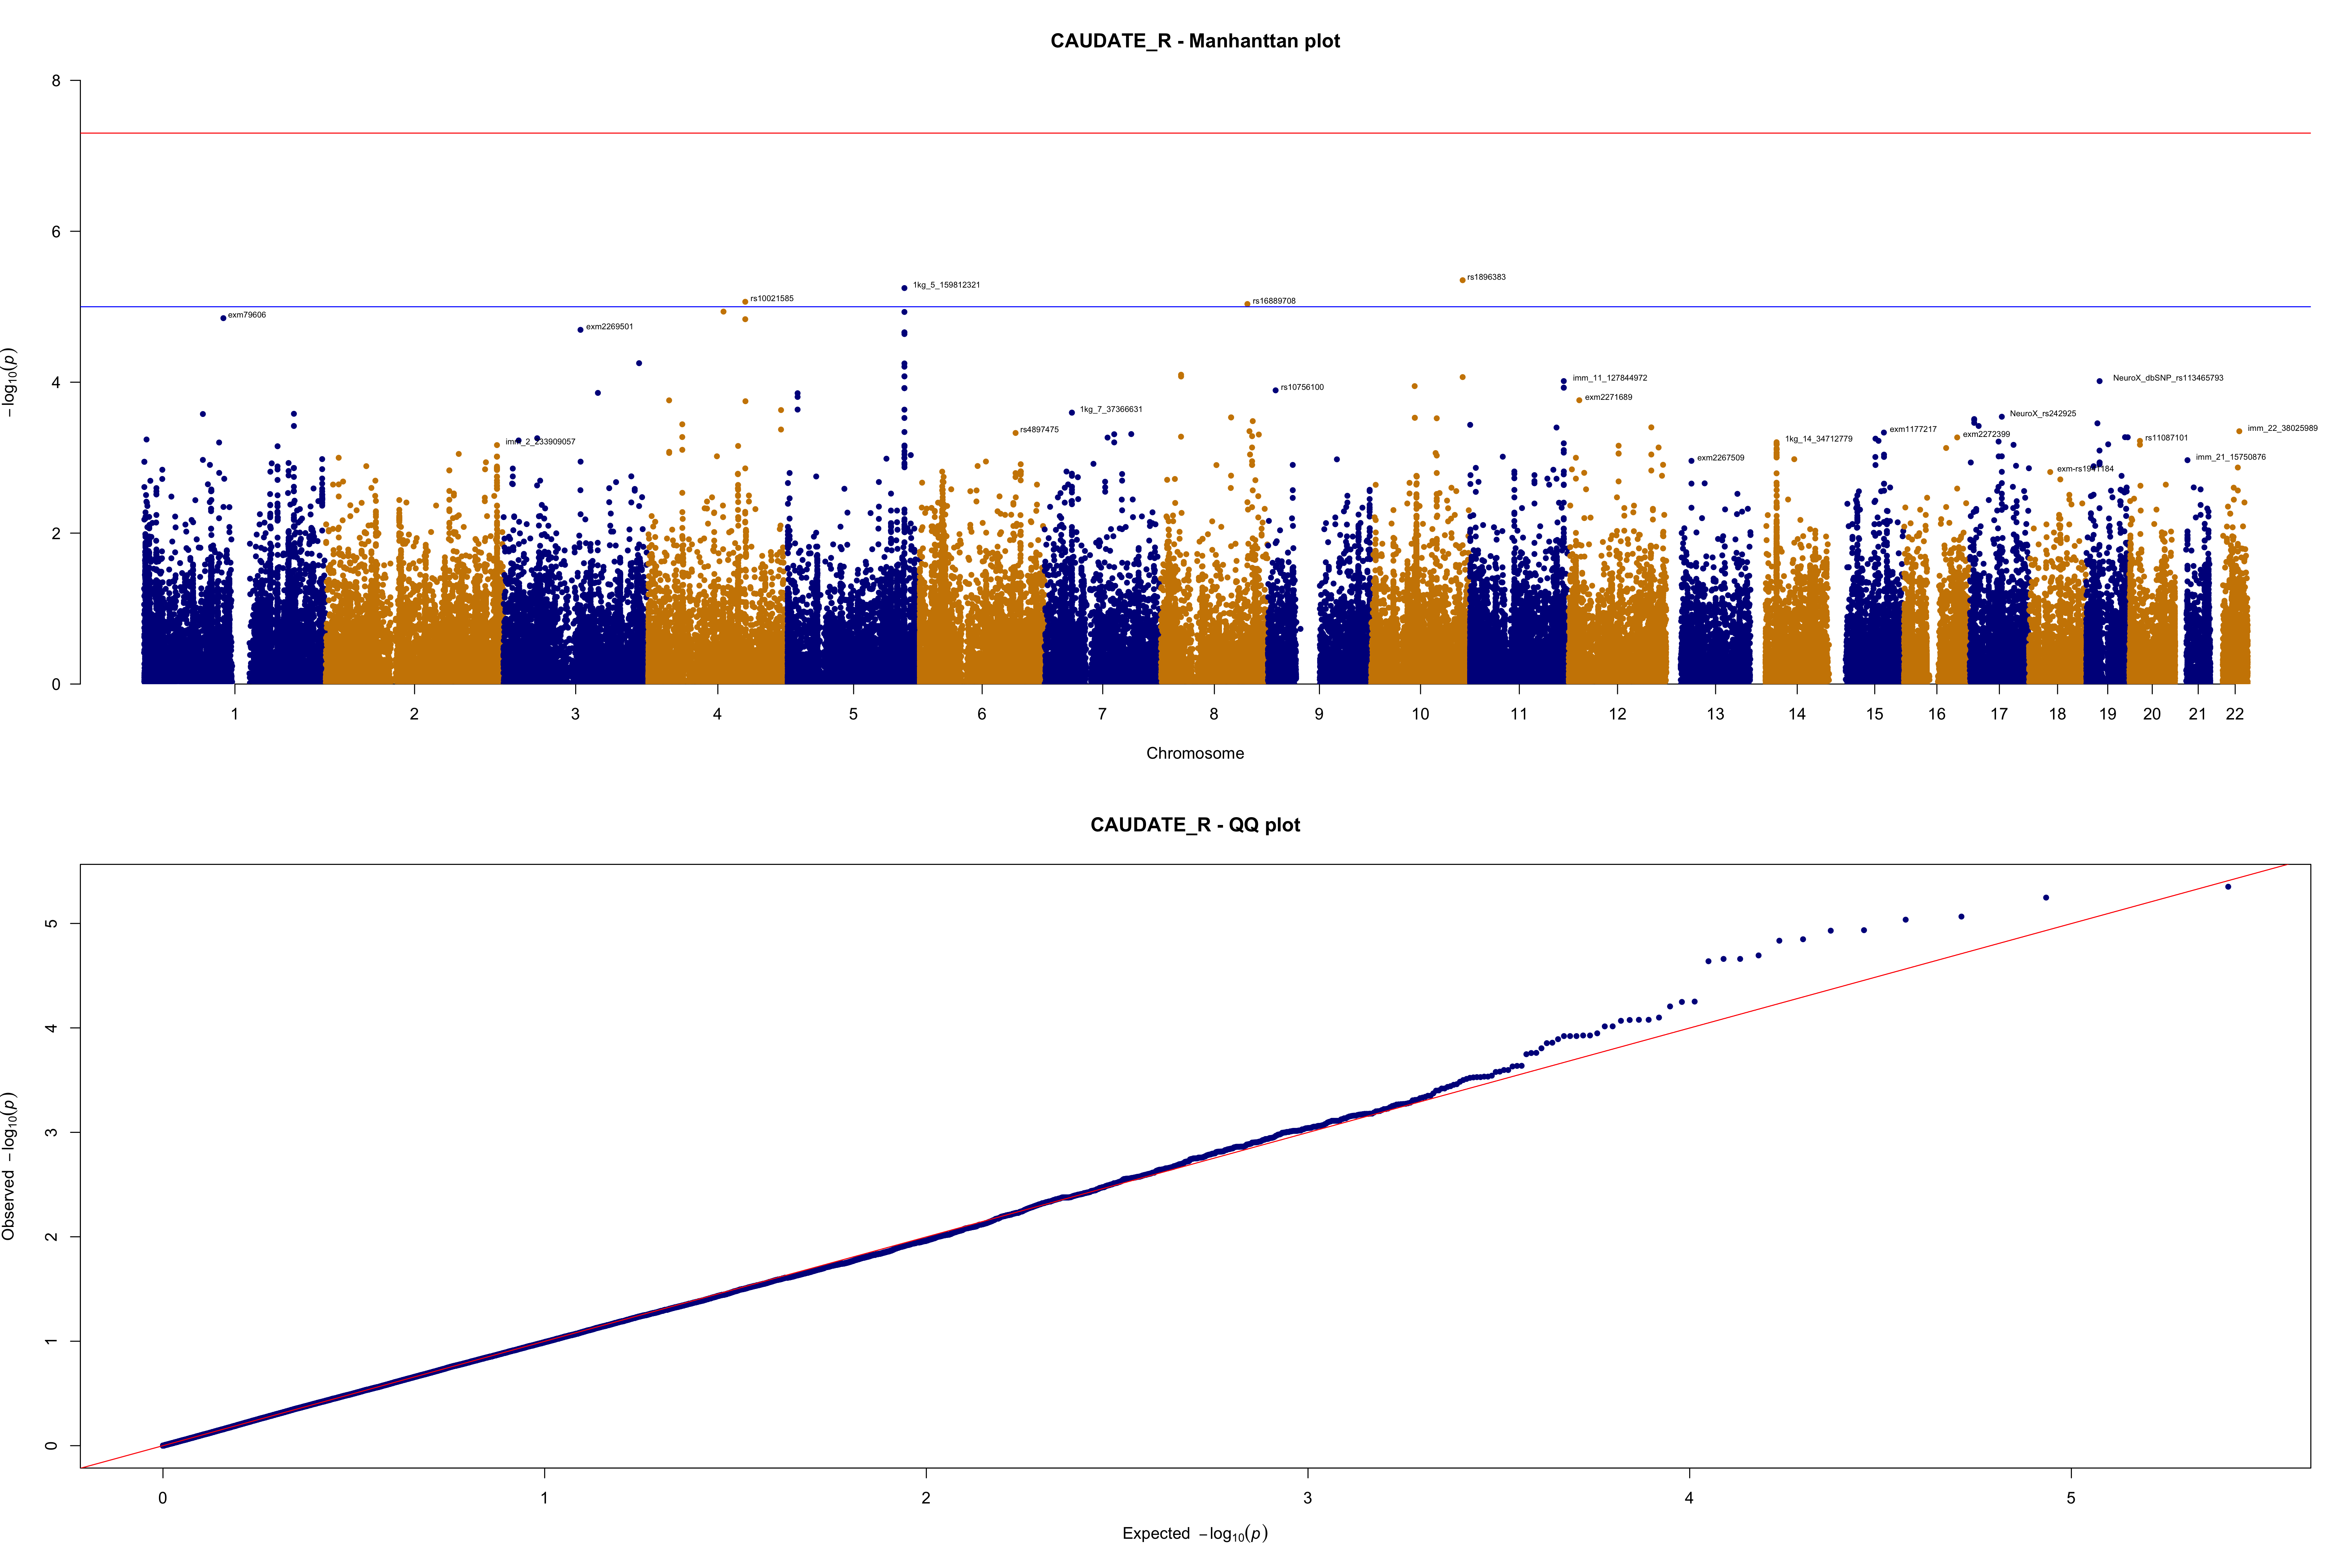

In [16]:
Image.open(os.path.join(indview_datscan_res_path, "CAUDATE_R.png"))

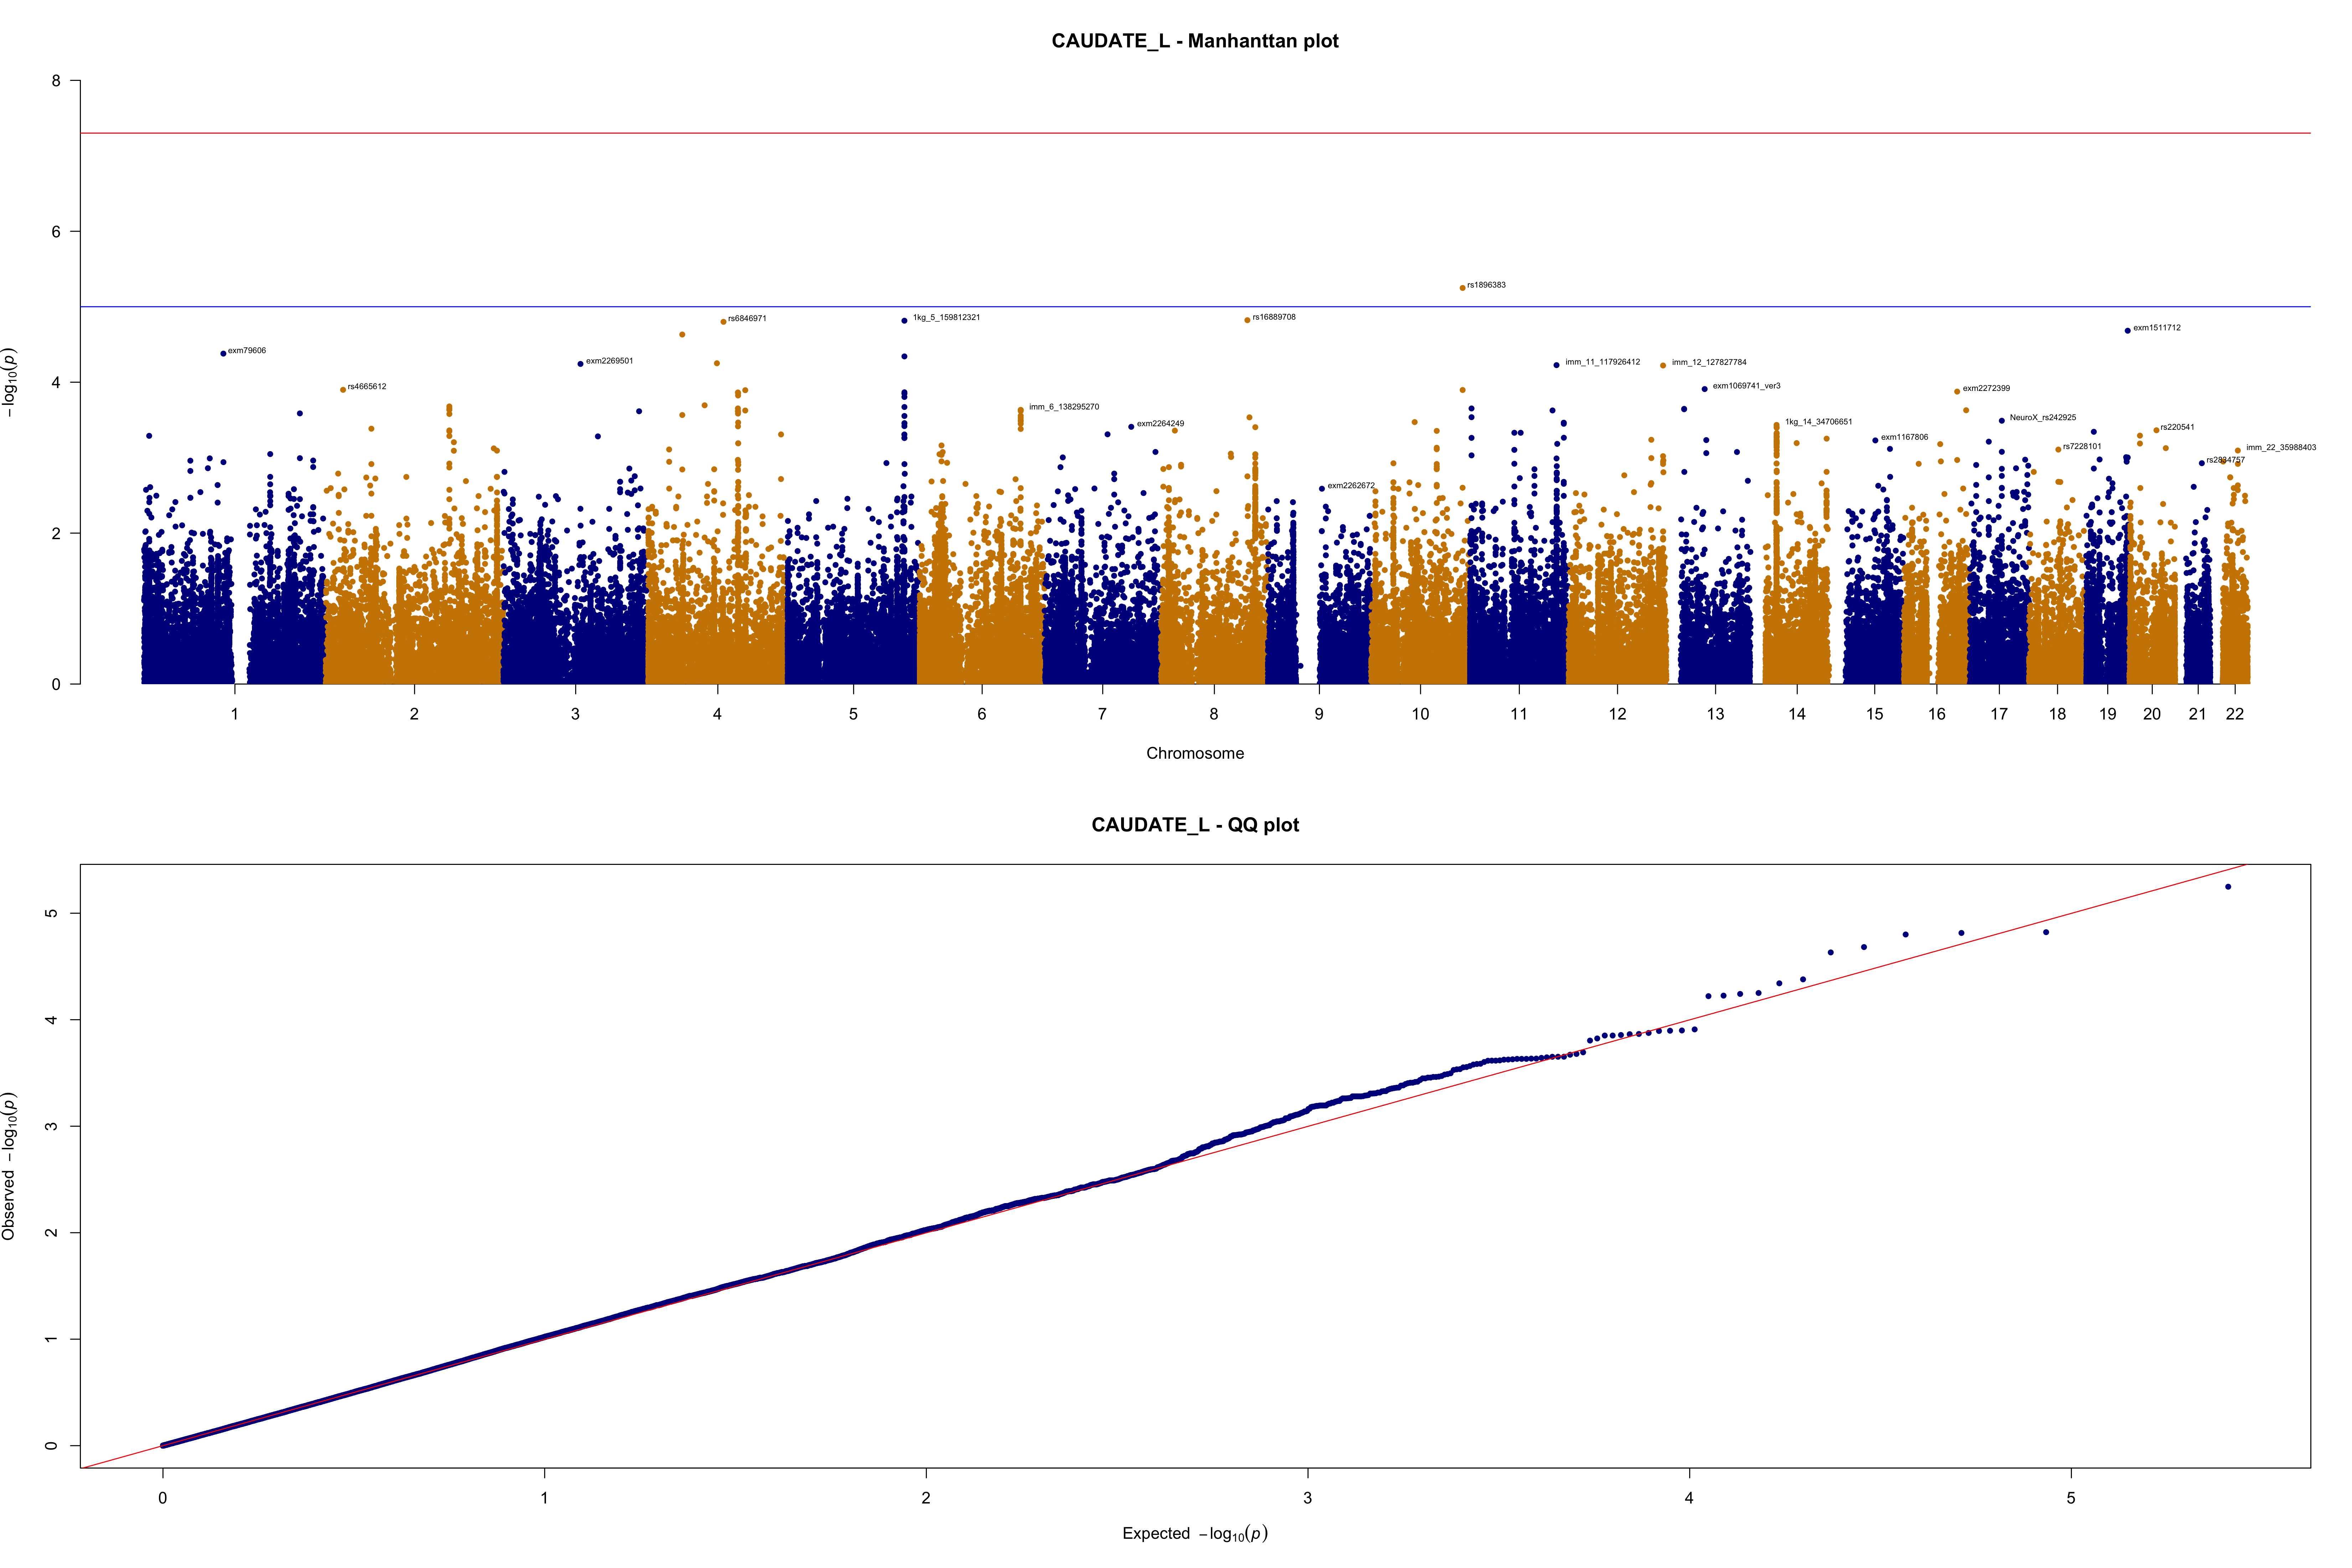

In [17]:
Image.open(os.path.join(indview_datscan_res_path, "CAUDATE_L.png"))

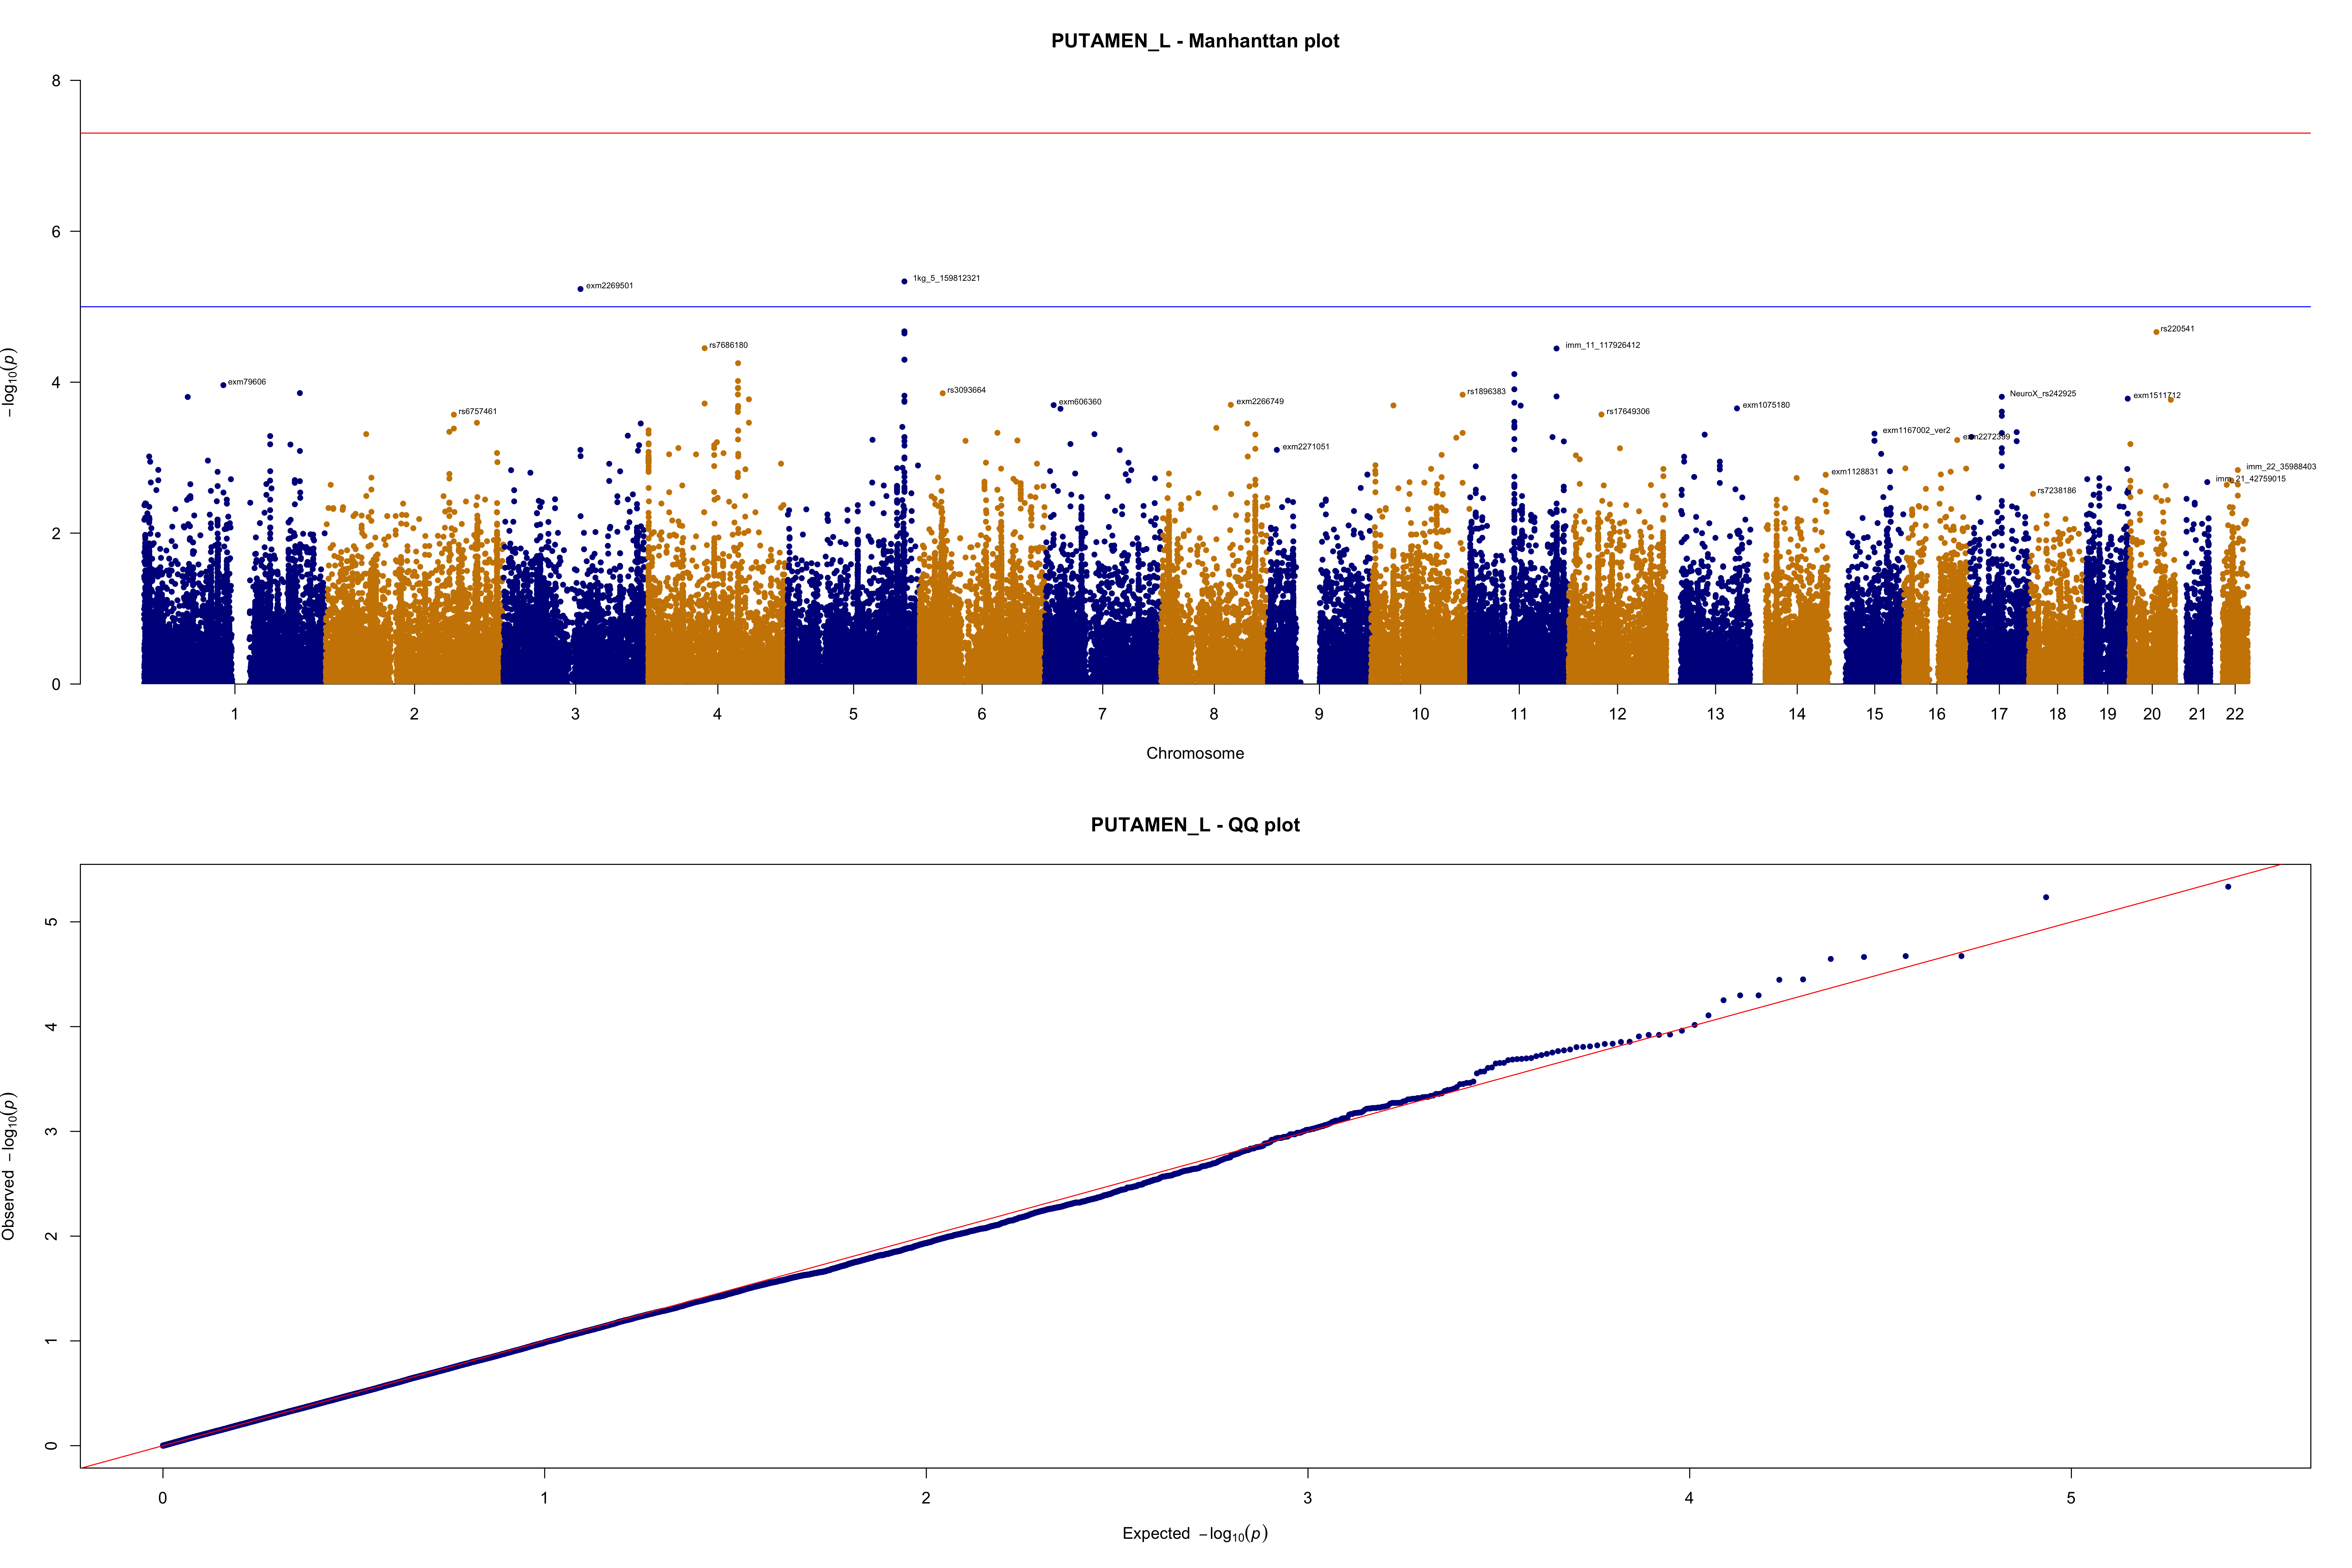

In [18]:
Image.open(os.path.join(indview_datscan_res_path, "PUTAMEN_L.png"))

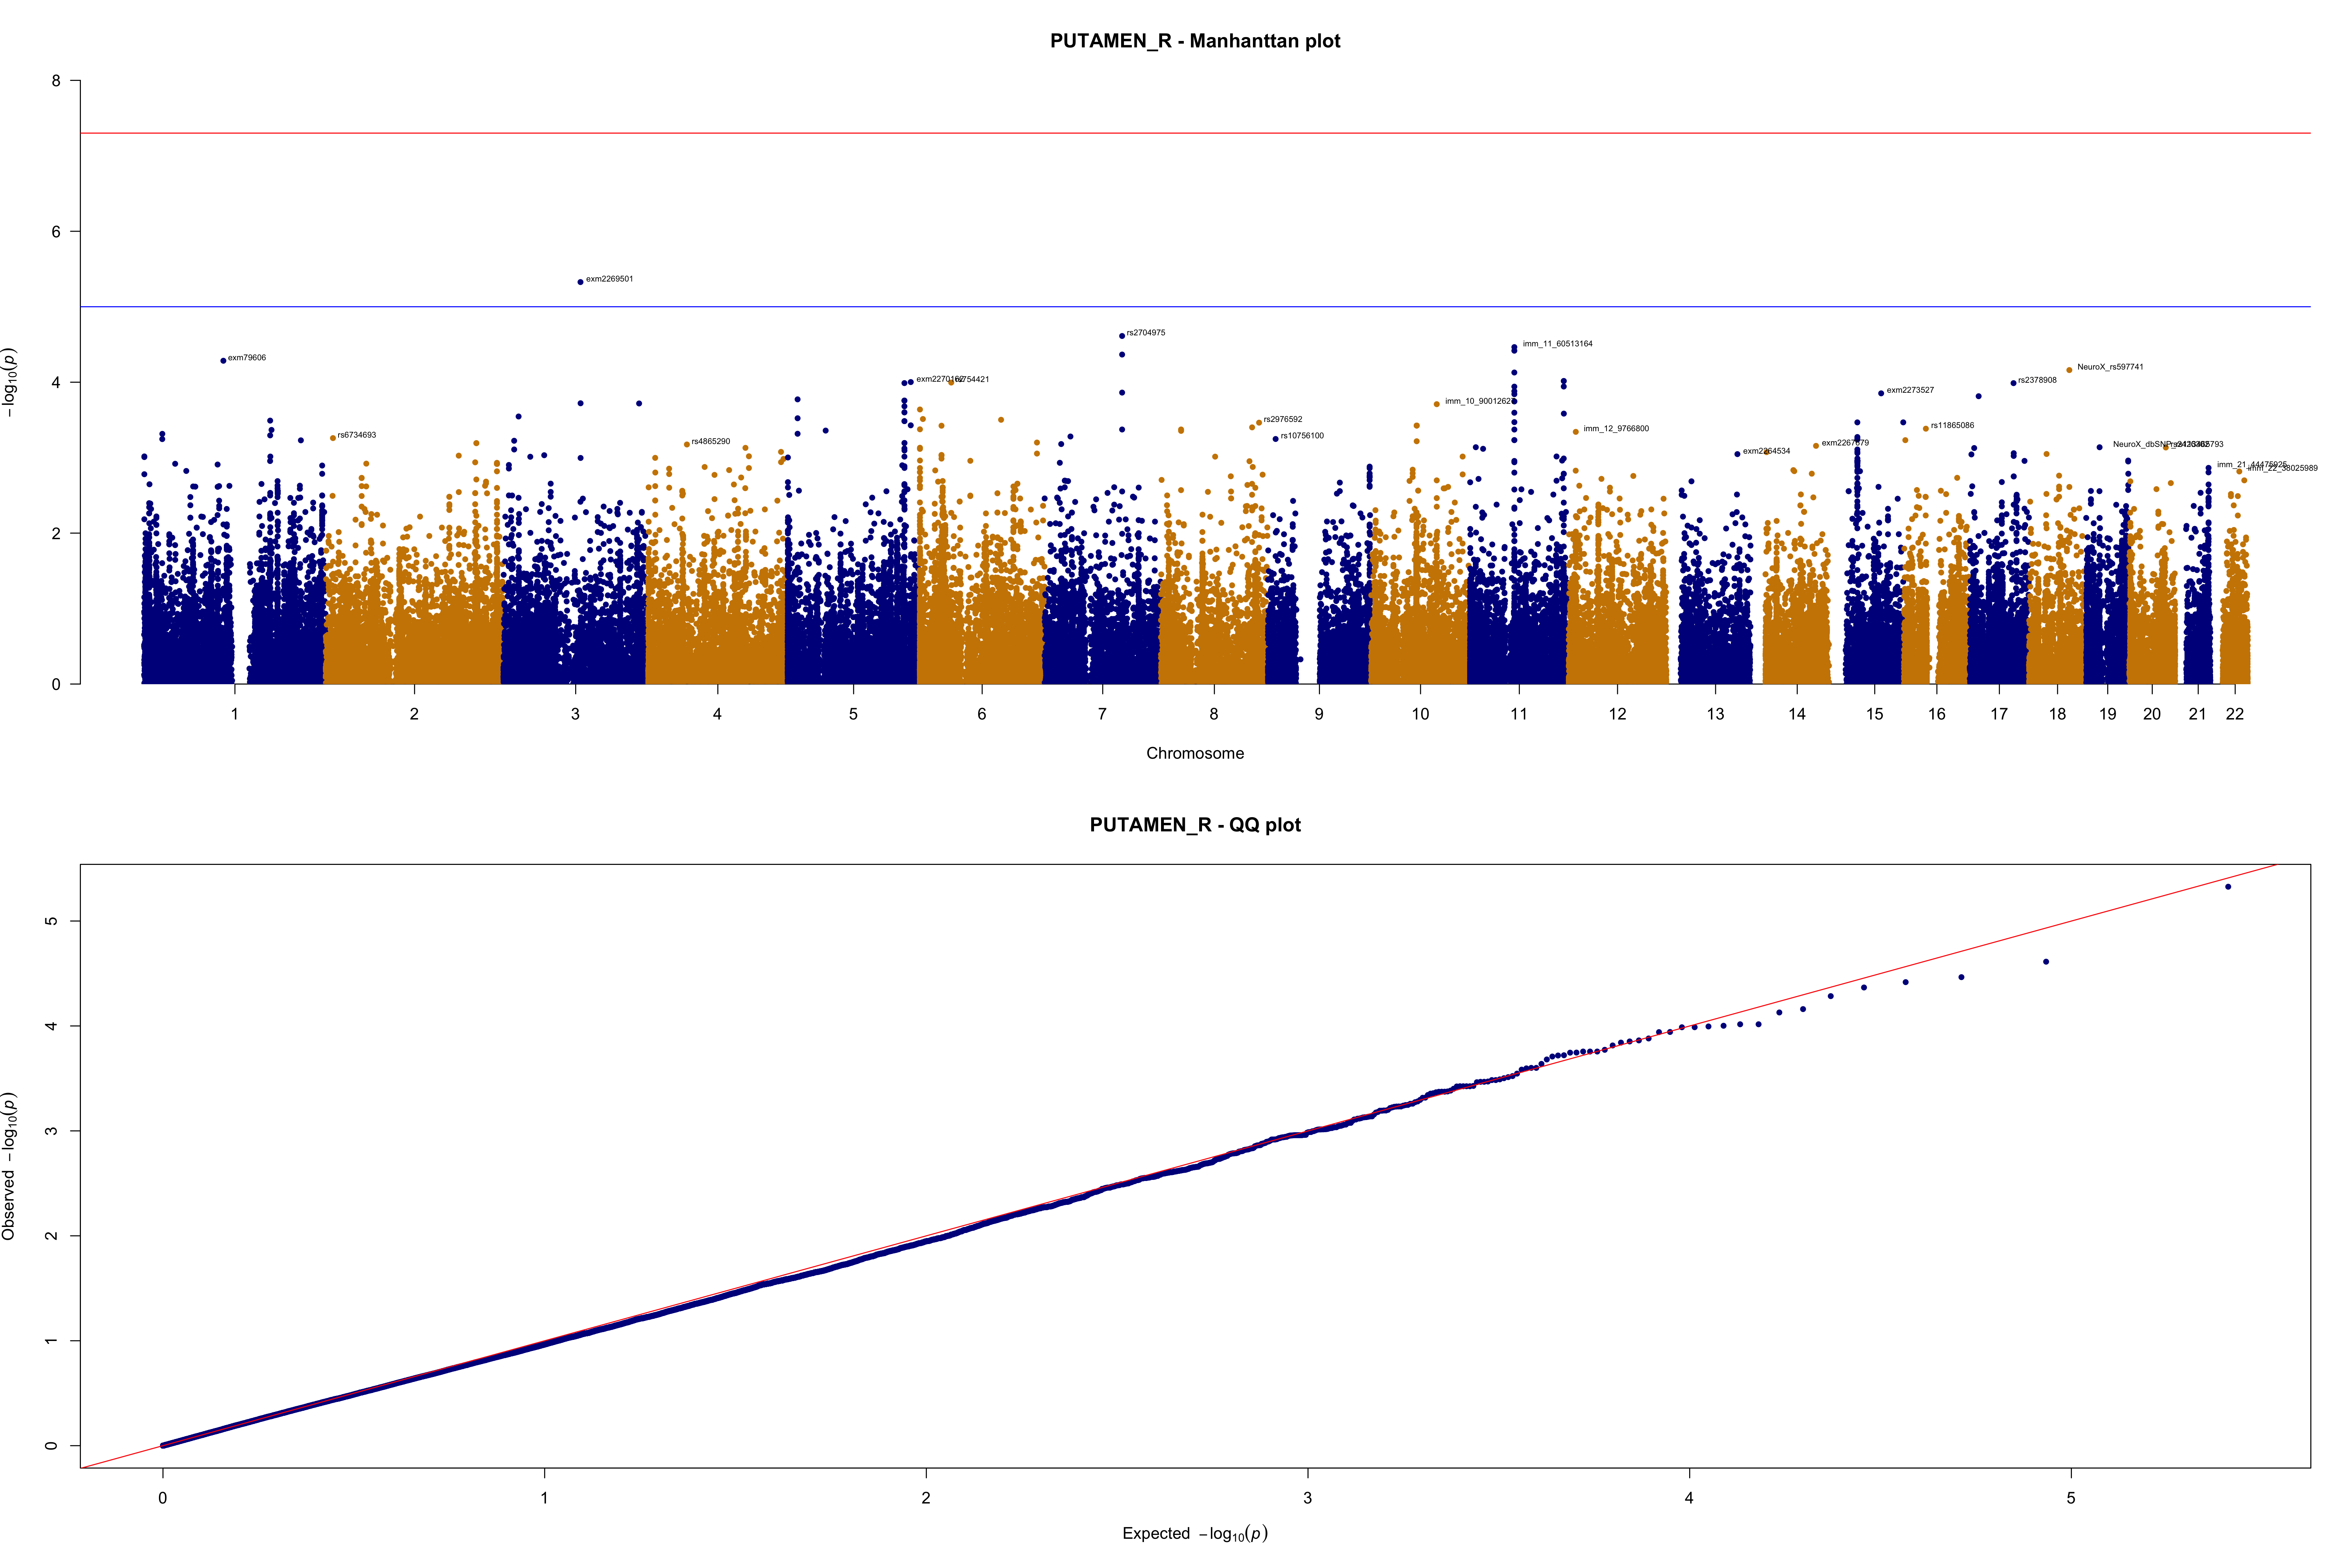

In [19]:
Image.open(os.path.join(indview_datscan_res_path, "PUTAMEN_R.png"))

We can observe that for each DaTSCAN feature we have at least one SNP over the significance threshold (*P*-value $ < 1e^{-5}$).

| **CAUDATE_R** | **CAUDATE_L** | **PUTAMEN_R** | **PUTAMEN_L** |
| --- | --- | --- | --- |
| rs10021585 | rs1896383 | exm2269501 | exm2269501 |
| 1_kg_5_159812321 | | | 1kg_5_159812321|
| rs16889708 | | | |
| rs1896383 | | | |
| | | | |

To have a consistent summary of all these results we must combine them together. To combine the results obtained during the GWAS we use TATES, which combines the P-values in a single-trait-based statistical significance, by correcting for correlation among the imaging features, and evaluating if at least one of the analyzed traits could be associated with a SNP.

## Combining GWAS results in a single-trait based summary statistics

To combine the GWAS results we use TATES (Van der Sluis *et al.*, 2013). To run TATES requires a file named ```defdims``` containing the parameters to run it, a file containing a correlation matrix of phenotype values used during GWAS analysis, and a file storing the single trait SNP-phenotype association *P*-values.

Let's begin by building the phenotype correlation matrix. 

In [20]:
tateswd = os.path.join(genotyping_path, "tates_datscan_wd")
!mkdir -p {tateswd}

In [21]:
phenotype_vals = np.array(phenotype.iloc[:, [3,4,5,6]])  # get only DaTSCAN uptake values
corr_mat = np.corrcoef(phenotype_vals, rowvar=False)  # observations on rows
corr_mat = np.float32(corr_mat)
corr_mat

array([[1.        , 0.8585894 , 0.8565082 , 0.72742146],
       [0.8585894 , 1.        , 0.7491696 , 0.85334384],
       [0.8565082 , 0.7491696 , 1.        , 0.77063686],
       [0.72742146, 0.85334384, 0.77063686, 1.        ]], dtype=float32)

In [22]:
corr_mat_fn = "corr_mat"
pd.DataFrame(corr_mat).to_csv(
    os.path.join(tateswd, corr_mat_fn),
    header=False,
    index=False,
    sep=" "
)

Now let's build the *P*-values file.

In [23]:
pvals_fn = "pvals"
pd.DataFrame(
    {
        0:caudate_r.iloc[:,0],  # chromosome
        1:caudate_r.iloc[:,1],  # SNP name
        2:caudate_r.iloc[:,8],  # caudate_r pvals
        3:caudate_l.iloc[:,8],  # caudate_l pvals
        4:putamen_r.iloc[:,8],  # putamen_r pvals
        5:putamen_l.iloc[:,8]   # putamen_l pvals
    }
).to_csv(
   os.path.join(tateswd, pvals_fn),
    header=False,
    index=False,
    sep=" "
)

Finally, we define the ```defdims``` file required by TATES, which specifies the files to use, during the *P*-value correction procedure. 

In [24]:
pheno_num = 4
corr_mat_type = "full"  # full correlation matrix
snp_num = len(caudate_l.iloc[:,8].tolist())
tates_res_fn = "tates_datscan_results"

towrite = "{0} {1}\n{2}\n{3}\n{4}\n{5}".format(
    pheno_num,  # number of phenotype
    snp_num,  # number of snps
    corr_mat_type,  # correlation matrix type
    pvals_fn,  # pvals file
    corr_mat_fn,  # correlation matrix file
    tates_res_fn
)

try:
    with open(os.path.join(tateswd, "defdims"), mode="w+") as outfile:
        outfile.write(towrite)
except Exception as e:
    raise e
finally:
    outfile.close()

Once we built all the files required by TATES, we can run it. 

**NB**. To run TATES executable must be placed in the same directory containing the required files.

In [25]:
cwd = os.getcwd()
os.chdir(tateswd) # go to tates dir
!./tates 
os.chdir(cwd)  # go back to origin

  starting 
  EVD of phenotypes finished 
  snp 1 to snps (every 10000 shown)
  SNP        10000      128812
  SNP        20000      128812
  SNP        30000      128812
  SNP        40000      128812
  SNP        50000      128812
  SNP        60000      128812
  SNP        70000      128812
  SNP        80000      128812
  SNP        90000      128812
  SNP       100000      128812
  SNP       110000      128812
  SNP       120000      128812
STOP end tates 


Now let's compute the new manhattan and quantile quantile plots.

In [26]:
!Rscript plot_tates_datscan.R

Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).

null device 
          1 


After the combination of the GWAS results we still have three significant SNPs:

- exm2269501

- 1kg_5_159812321

- rs1896383

In [27]:
tates_res = pd.read_csv(
    os.path.join(tateswd, tates_res_fn),
    header=None,
    sep="\s+"
)
tates_res[tates_res[3] < 1e-5].iloc[:,1].tolist() # get SNPs with P-value < 1e-5

['exm2269501', '1kg_5_159812321', 'rs1896383']

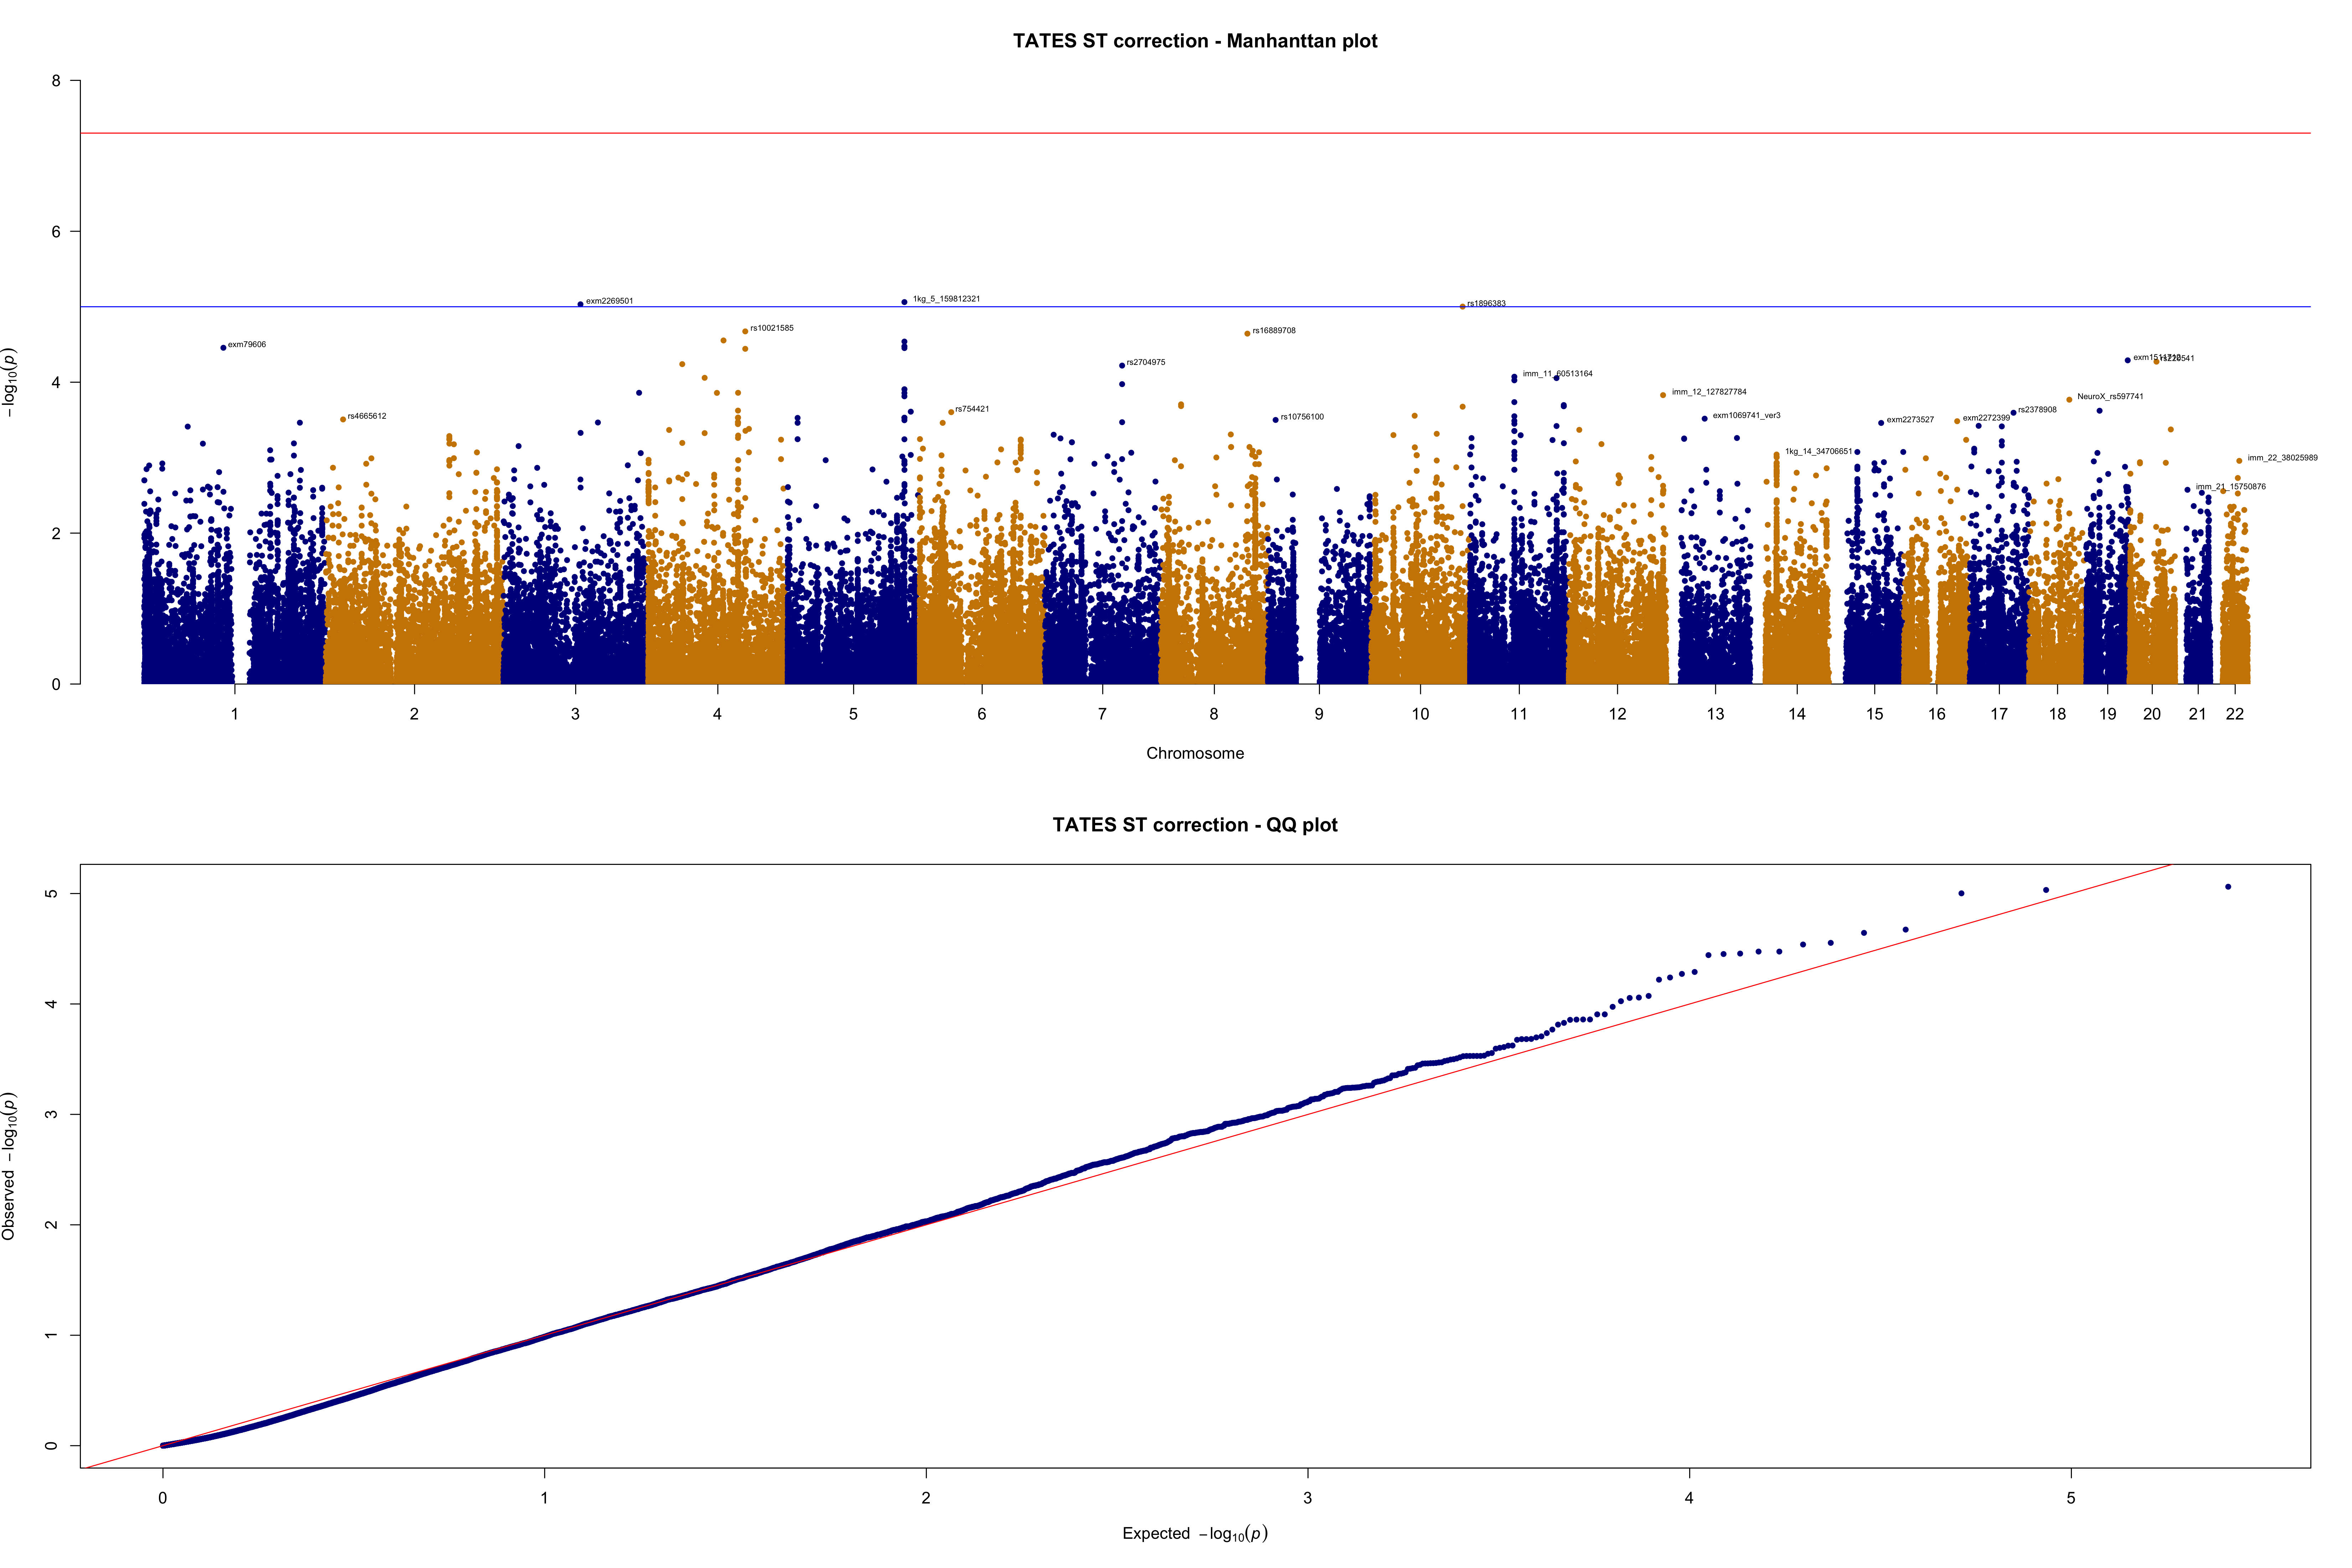

In [28]:
Image.open(os.path.join(indview_datscan_res_path, "tates_st_correction.png"))